# PH7013
Sample code from https://qutip.org/docs/latest/guide/dynamics/dynamics-time.html

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from qutip import *

import qutip_qip
from qutip_qip.circuit import QubitCircuit
from qutip.qip.operations import *
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor, Processor
from qutip_qip.noise import Noise
from qutip.qip.pulse import Pulse
from qutip.qip.gates import *

from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

import functools # for reduce
from joblib import Parallel, delayed  # for parallel simulations
import itertools # for RB inverse search

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_30644\187828302.py:15: DeprecationWarning: Importation from qutip.qip.gates is deprecated.Please use e.g.
 from qutip.qip.operations import cnot

  from qutip.qip.gates import *


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
with open("rename.py") as f:
    exec(f.read())

## Finding pulse duration

Parameters

In [3]:
VStd = 0.1
phaseStd = 0.382 / 180 * np.pi

detuningStd = 52769
samplingRate = 5898.24e6 # 5.89824 GS/s
omega = 20e6 # 20MHz

VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

V = VNaught + np.random.normal(scale=VStd)
phi = phiNaught + np.random.normal(scale=phaseStd)
I = np.cos(phi)
Q = np.sin(phi)

T1 = 8.66e-6
T1_err = 0.49
T2 = 9.08e-6
T2_err = 0.74e-6
T2_echo = 16.14e-6
T2_echo_err = 3.21e-6

Finding the pulse duration. When specifying Python functions for coefficients, the function must have (t,args) as the input variables, in that order.

In [4]:
# This code takes 2 minutes to run, maybe sesolve is not optimized for this
psi0 = basis(2,0)
t_0 = 0
t_final = 100e-9
n_steps = int(samplingRate * (t_final - t_0))
t_find_pulse = np.linspace(t_0, t_final, n_steps)
def H_find_pulse(t, args):
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / t_final)
    # For 2 qubit
    # return omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * tensor(identity(2),sigma_x()) + (I * np.sin(dwt) - Q * np.cos(dwt)) * tensor(identity(2),sigma_y()))
    return omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigma_x() + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigma_y())
# For 2 qubit
# result_find_pulse = sesolve(H_find_pulse, psi0, t_find_pulse, [tensor(sigmaz(),sigmaz())],options=Options(nsteps=10000))
result_find_pulse = sesolve(H_find_pulse, psi0, t_find_pulse, [sigmaz()],options=Options(nsteps=10000))

(<Figure size 800x400 with 1 Axes>,
 array([[<Axes: xlabel='time'>]], dtype=object))

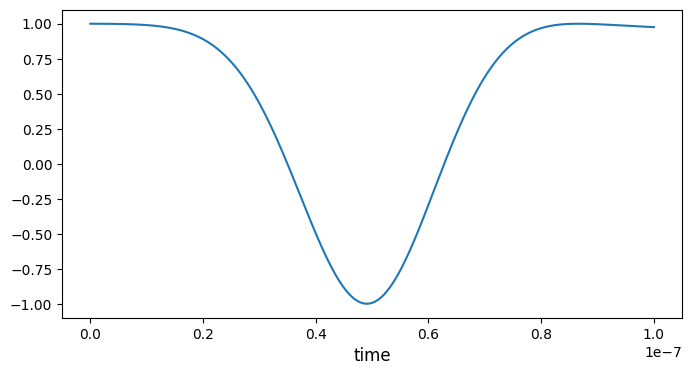

In [5]:
plot_expectation_values(result_find_pulse)

Find the pi-pulse by optimizing

In [6]:
minimum_array = argrelextrema(result_find_pulse.expect[0], np.less)
first_min = minimum_array[0][0]
pi_pulse_duration = result_find_pulse.times[first_min]
pi_half_pulse_duration = pi_pulse_duration/2
print(pi_pulse_duration,pi_half_pulse_duration)

4.9149659863945575e-08 2.4574829931972788e-08


Solving the Hamiltonian

In [7]:
def H(t, args):
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / pi_pulse_duration)
    # return omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * tensor(identity(2),sigma_x()) + (I * np.sin(dwt) - Q * np.cos(dwt)) * tensor(identity(2),sigma_y()))
    return omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigma_x() + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigma_y())

In [8]:
n_steps = int(samplingRate * (pi_pulse_duration - t_0))
t = np.linspace(t_0, pi_pulse_duration, n_steps)
# result = sesolve(H, psi0, t, [tensor(identity(2),sigmaz()),tensor(identity(2),sigmax()),tensor(identity(2),sigmay())],options=Options(nsteps=10000))
result = sesolve(H, psi0, t, [sigmaz(),sigmax(),sigmay()],options=Options(nsteps=10000))

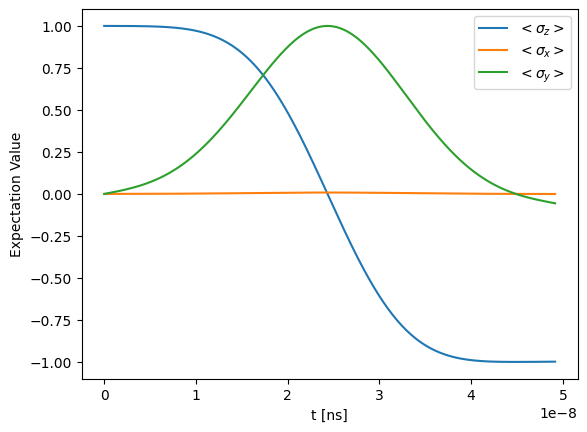

In [9]:
plt.plot(t, np.transpose(result.expect), label=[r"$<\sigma_z>$", r"$<\sigma_x>$", r"$<\sigma_y>$"])
plt.xlabel("t [ns]")
plt.ylabel("Expectation Value")
plt.legend()

## Customize device

Built a Hamiltonian model for a device with 2 single qubit control: $\sigma_x$ and $\sigma_y$

In [10]:
class MyProcessor(ModelProcessor):
    """
    Custom processor built using ModelProcessor as the base class.
    This custom processor will inherit all the methods of the base class
    such as setting up of the T1 and T2 decoherence rates in the simulations.

    In addition, it is possible to write your own functions to add control
    pulses.

    Args:
        num_qubits (int): Number of qubits in the processor.
        t1, t2 (float or list): The T1 and T2 decoherence rates for the
    """

    def __init__(self, num_qubits, t1=None, t2=None):
        # call the parent class initializer
        super(MyProcessor, self).__init__(num_qubits, t1=t1, t2=t2)  
        # The control pulse is discrete or continous.
        self.pulse_mode = "discrete"
        # The dimension of each controllable quantum system
        self.model.dims = [2] * num_qubits
        self.num_qubits = num_qubits
        self.set_up_ops()  # set up the available Hamiltonians

    def set_up_ops(self):
        """
        Sets up the control operators.
        """
        # sigmax pulse on m-th qubit with the corresponding pulse
        for m in range(self.num_qubits):
            self.add_control(2 * np.pi * sigmax(), m, label="sx" + str(m))
        # sy
        for m in range(self.num_qubits):
            self.add_control(2 * np.pi * sigmay(), m, label="sy" + str(m))


Define the compiling routines for the two types of rotation gates RX and RY with the driving Hamiltonian:

\begin{equation}
    \mathcal{H} = \Omega V_0 s(t) ( (-I\cos{(\delta \omega t)} + Q\sin{(\delta \omega t)})\sigma_x + (I\sin{(\delta \omega t)}-Q\cos{(\delta \omega t)})\sigma_y)
\end{equation}

In [11]:
class MyCompiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "RX": self.single_qubit_gate_compiler,
            "RY": self.single_qubit_gate_compiler,
        }

    def single_qubit_gate_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
            (Note: Instruction class includes args:
                tlist (array): A list of times for the evolution.
                coeff (array): An array of coefficients for the gate pulses
            )

        """

        # Rotation angle
        phiNaught = gate.arg_value[1]
        
        # Parameters
        V = VNaught + np.random.normal(scale=VStd)
        phi = phiNaught + np.random.normal(scale=phaseStd)
        I = np.cos(phi)
        Q = np.sin(phi)

        # Find tlist (list of time steps) for pi pulse or pi-half pulse
        ratio_of_pi_pulse = gate.arg_value[0]
        if ratio_of_pi_pulse == 0.5:
            n_steps = int(samplingRate * (pi_pulse_duration/2 - t_0))
            tlist = np.linspace(t_0, pi_pulse_duration/2, n_steps) 
        else:
            n_steps = int(samplingRate * (pi_pulse_duration - t_0))
            tlist = np.linspace(t_0, pi_pulse_duration, n_steps)        

        # Find coeff for sigma x and sigma y (from Hamiltonian)
        dwt = np.random.normal(scale=detuningStd) * tlist
        s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * tlist / pi_pulse_duration)

        coeff_x = np.sign(gate.arg_value[1])*np.asarray([omega * np.pi * V * s[i] * (-I * np.cos(dwt[i]) + Q * np.sin(dwt[i])) for i in range(len(s))])
        coeff_y = np.sign(gate.arg_value[1])*np.asarray([omega * np.pi * V * s[i] * (I * np.sin(dwt[i]) - Q * np.cos(dwt[i])) for i in range(len(s))])

        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), coeff_x),
            ("sy" + str(gate.targets[0]), coeff_y),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

Define an example circuit.

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_30644\1781697136.py:5: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  circuit = QubitCircuit(num_qubits)


0.5496213393192099


C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_30644\1781697136.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


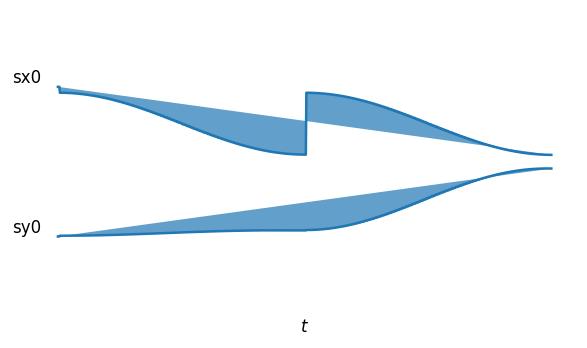

In [151]:
# Define a circuit and run the simulation

num_qubits = 1

circuit = QubitCircuit(num_qubits)
circuit.add_gate("RY", targets=0, arg_value=[0.5,-np.pi])
circuit.add_gate("RX", targets=0, arg_value=[0.5,-np.pi])

myprocessor = MyProcessor(num_qubits)
myprocessor.native_gates = ["RX", "RY"]

init_state = basis(2, 0)
mycompiler = MyCompiler(num_qubits,{})

myprocessor.load_circuit(circuit, compiler=mycompiler)
result = myprocessor.run_state(init_state)
print(fidelity(result.states[-1], init_state))

fig, ax = myprocessor.plot_pulses(figsize=(5, 3), dpi=120, use_control_latex=False)
ax[-1].set_xlabel("$t$")
fig.tight_layout()
# Ignore the shading

## Randomized Benchmarking

Simulation for a random circuit

In [152]:
gates_set = [
    Gate("RX", 0, arg_value=[0,0]), # X Pulse
    Gate("RY", 0, arg_value=[0,np.pi / 2]), # Y Pulse
    Gate("RX", 0, arg_value=[0.5,0]), # X Half Pulse
    Gate("RY", 0, arg_value=[0.5,np.pi / 2]), # Y Half Pulse
    Gate("RX", 0, arg_value=[0.5,-np.pi]), # X Minus Half Pulse
    Gate("RY", 0, arg_value=[0.5,-np.pi / 2]), # Y Minus Half Pulse
]

matrix_list = [
    rx(np.pi), # X
    ry(np.pi), # Y,
    rx(np.pi / 2), # X/2
    ry(np.pi / 2), # Y/2
    rx(-np.pi / 2), # -X/2
    ry(-np.pi / 2), # -Y/2
    rx(0)
]

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_30644\3169564732.py:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  Gate("RX", 0, arg_value=[0,0]), # X Pulse
C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_30644\3169564732.py:3: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  Gate("RY", 0, arg_value=[0,np.pi / 2]), # Y Pulse
C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_30644\3169564732.py:4: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip

In [153]:
def single_simulation(num_gates):
    """
    A single simulation, with num_gates representing the number of rotations.

    Args:
        num_gates (int): The number of random gates to add in the simulation.

    Returns:
        result (qutip.solver.Result):
            A qutip Result object obtained from any of the
            solver methods such as mesolve.
    """
    num_qubits = 1
    myprocessor = MyProcessor(num_qubits,t1=T1,t2=T2)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = MyCompiler(num_qubits,{})
    
    # Ground state for n qubits
    init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

    # Define a random circuit.
    circuit = QubitCircuit(num_qubits)
    clifford = rx(0)
    for ind in np.random.randint(0, 6, num_gates):
        circuit.add_gate(gates_set[ind])
        clifford = clifford * matrix_list[ind]
    
    # Finding inverse clifford and adding the pulse in
    x = inverse_search(clifford*ground_state,matrix_list,init_state)
    if x == None:
        raise RuntimeError("Could not find an inverse Clifford")
    elif not x[0] == 6 and not x[1] == 6:
        circuit.add_gate(gates_set[x[1]])
        circuit.add_gate(gates_set[x[0]])
    elif x[0] == 6 and not x[1] == 6:
        circuit.add_gate(gates_set[x[1]])
    elif x[1] == 6 and not x[0] == 6:
        circuit.add_gate(gates_set[x[0]])
    
    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)

    # increase the maximal allowed steps
    # options = Options(nsteps=10000)
    # e_ops = [tensor([qeye(2), fock_dm(2)])]  # observable

    # compute results of the run using a solver of choice
    result = myprocessor.run_state(init_state, solver="mesolve")
    
    # measured fidelity at the end
    final_fidelity = fidelity(result.states[-1], init_state)
    return final_fidelity

The simulation is repeated 20 times to obtain average fidelity

In [149]:
# Takes about 4 min

num_sample = 20
fidelity_average = []
fidelity_error = []
init_fid = 1
num_gates_list = np.arange(25,225,25)

for num_gates in num_gates_list:
    fidelity_list = [single_simulation(num_gates) for i in range(num_sample)]
    fidelity_average.append(np.mean(fidelity_list))
    fidelity_error.append(np.std(fidelity_list) / np.sqrt(num_sample))

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_30644\2440393902.py:22: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  circuit = QubitCircuit(num_qubits)
C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_30644\2440393902.py:23: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  clifford = rx(0)
C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_30644\2440393902.py:22: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qi

Text(0, 0.5, 'Ground State Fidelity')

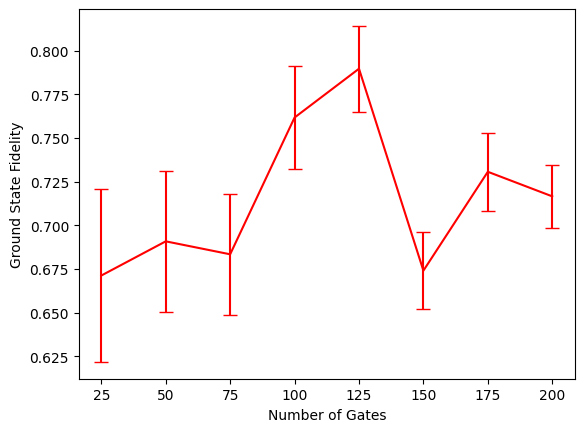

In [150]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_average, yerr=fidelity_error, color='red', capsize=5)
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")